# Paramètres

In [100]:
#génération du graphe
nbIndividuals = 1000 # #nbIndividus | number of people in the graph | nombre d'individus dans le graphe
deg_avg = 100 # | deg_moy | average number of connexions per person | le nombre moyen de connexions par personne
household_size = 6 # avergave size of household | la taille moyenne d'un foyer
household_proba = 1 # probability of meeting a person of the same household | la probabilité de contact par jour entre membres d'un même foyer
extern_contact_proba = 0.3 # probabilty of meeting a person of a different household | la probabilité de contact par jour entre personne de foyers différents

UtilApp = 0.8 # percentage of people having the app | la proportion d'utilisateurs de l'application dans la population générale
InitSane = 0.99 # InitSain | percentage of healthy people at start | la proportion de personnes saines à l'intant initial (les autres sont porteurs asymptomatiques)

# application
daysNotif = 14 # joursNotif

pDetection = 0.9
pReport = 0.9   # pSignalement
pQNotif = 0.8 # probablity of going into quarantine when recieving a notification | proba de mise en confinement lors de la réception d'une notification

# probas
pContamination = 0.02 # probabilty of contaminating another individual | proba de contaminer un autre individu

pAtoG = 0.07 # probability of going from asymptomatic state to cured | proba de passer de asymptomatique à guéri
pAtoIS = 0.02 # probability of going from asymptomatic state to symptomatic state | passage de asymptomatique à avec symptomes
pAtoD = 0.0001 # probability of dying when asymptomatic | proba de décès

pIStoG = 0.07 # probability of going from symptomatic state to cured | proba de passer de avec symptomes à gueri
pIStoD = 0.01 # probability of dying when symptomatic 

pQSymptoms = 0.9 # probability of going into quarantine when one has symptoms | proba confinement lors de détection des symptomes

confinementFactor = 100 # facteurConfinement | reduction factor applied to the probabilities when one is in quarantine | réduction des probas de rencontre lors du confinement
daysConfinement = 14 # jourConfinement | duration of the confinement/quarantine

In [101]:
# Librairies
import random
import math as m

In [102]:
SANE = 0
ASYMP = 1
SYMP = 2
CURED = 3
DEAD = 4

nbS = 0
nbAS = 0
nbSane = 0
nbDead = 0
nbCured = 0
nbQuarantine = 0

In [103]:
individuals = []
adj = []

# Génération du graphe

In [104]:
# graph initialisation

def init_graph():
    global nbSane
    global nbAS
    global individuals
    global adj
    
    individuals = []
    adj = []
    
    # creating of individuals
    for i in range(nbIndividuals):
        app = False
        if random.uniform(0,1) < UtilApp:
            app = True

        s = ASYMP
        if random.uniform(0,1) < InitSane:
            s = SANE
            nbSane +=1
        else:
            nbAS +=1

        individuals.append({"state": s, "confined": False, "daysConfinement": 0, "app": app})

    def get_matching(u, distrib):
        a = 0
        b = len(distrib)-1
        if (u > distrib[b]):
            return b
        else:
            while (b-a > 1):
                m = (a+b)//2
                if distrib[m] > u:
                    b = m
                else:
                    a = m
            m = (a+b)//2

            if distrib[m] > u:
                return a + 1
            else:
                return b + 1

    def not_empty(l):
        for x in l:
            if x > 0:
                return True
        return False


    def get_ind(x, degrees):
        s = 0
        for i in range(len(degrees)):
            s += degrees[i]
            if x <= s:
                return i

    def random_pair(S, degrees):
        x1 = random.randint(1, S)
        x2 = random.randint(1, S)
        ind1 = get_ind(x1, degrees)
        ind2 = get_ind(x2, degrees)
        return ind1, ind2

    distrib = [1 - m.exp(-1/deg_avg)] #for k = 0

    degrees = []

    for k in range(1, 100):
        p = (1 - m.exp(-1/deg_avg)) * m.exp(-k/deg_avg)
        distrib.append(distrib[k-1] + p)

    for i in range(nbIndividuals):
        u = random.uniform(0, 1)
        deg = get_matching(u, distrib)
        degrees.append(deg)

    #to get an even number of total degrees
    S = sum(degrees)
    if S%2 == 1:
        degrees[0] += 1

    for i in range(nbIndividuals):
        adj.append([])

    while S > 0:
        p1, p2 = random_pair(S, degrees)
        if degrees[p1] <= household_size or degrees[p2] <= household_size:
            adj[p1].append({"node" : p2, "proba" : household_proba})
            adj[p2].append({"node" : p1, "proba" : household_proba})
        else:
            adj[p1].append({"node" : p2, "proba" : extern_contact_proba})
            adj[p2].append({"node" : p1, "proba" : extern_contact_proba})
        degrees[p1] -= 1
        degrees[p2] -= 1
        S -= 2

# Fonctions de gestion du graphe

In [105]:
encounters = [[[] for jour in range(daysNotif)] for individual in range(nbIndividuals)]

In [106]:
def contamination(i, j):
    global nbSane
    global nbAS
    global individuals
    if individuals[i]['state'] == individuals[j]['state']:
        return
    if individuals[i]['state'] >= CURED or individuals[j]['state'] >= CURED:
        return # cannot infect cured or dead individuals | on ne peut pas contaminer les individus guéris ou décédés
    
    if individuals[i]['state'] == SANE:
        contamination(j, i)
        return
    
    if individuals[j]['state'] != SANE or random.random() > pContamination:
        return # no contamination

    nbSane -= 1
    nbAS += 1
    individuals[j]['state'] = ASYMP

In [107]:
# Step from a day to the next day | Passage au jour suivant du graphe
def step():
    global nbSane
    global nbS
    global nbAS
    global nbDead
    global nbCured
    global nbQuarantine
    global individuals
    
    for encounter in encounters:
        encounter.append([]) # will contain every encounter of the day | contiendra les nouvelles rencontres du jour

    # For each possible encounter | On constate toutes les rencontres entre individus
    for i in range(nbIndividuals):
        for edge in adj[i]:
            j = edge['node']
            if j < i:
                continue # only check one way of the edge | on ne regarde qu'un sens de chaque arête
            
            factor = 1
            if individuals[i]['daysConfinement'] > 0:
                factor *= confinementFactor
            if individuals[j]['daysConfinement'] > 0:
                factor *= confinementFactor
            
            # if i or j are in quarantine, reduce the probability that they meet | Si i et/ou j sont confinés, réduction de leur proba de rencontre
            if random.random() > edge['proba'] / factor: 
                continue # no encounter | pas de rencontre
        
            # if i and j have the app, we save their encounter | Si i et j ont l'appli, on note la rencontre
            if individuals[i]['app'] and individuals[j]['app'] and random.random() < pDetection: 
                encounters[i][-1].append(j) 
                encounters[j][-1].append(i)
            
            contamination(i, j)
    
    # handle new day | On passe au jour suivant
    nbQuarantine = 0
    for i in range(nbIndividuals):
        individuals[i]['daysConfinement'] -= 1
        if individuals[i]['daysConfinement'] > 0:
            nbQuarantine += 1

    # update the states | on met à jour les états des individus
    for i, individual in enumerate(individuals):
        if individual['state'] == ASYMP:
            action = random.random()
            if action < pAtoG:
                nbAS -= 1
                nbCured += 1
                individual['state'] = CURED
            elif action > 1 - pAtoIS:
                nbAS -= 1
                nbS += 1
                individual['state'] = SYMP
                
                # send the notifications (encounters[i] is empty if i hasn't the app | envoi des notifs (rencontres[i] vide si i n'a pas l'appli)
                for daysEncounter in encounters[i]:
                    for contact in daysEncounter:
                        if random.random() < pQNotif:
                            individuals[contact]['daysConfinement'] = daysConfinement
                
                if random.random() < pQSymptoms: # go into quarantine if symptoms appear | mise en confinement à la détection des symptomes
                    individual['daysConfinement'] = daysConfinement
                
        elif individual['state'] == SYMP:
            action = random.random()
            if action < pIStoG:
                nbS -= 1
                nbCured += 1
                individual['state'] = CURED
            elif action > 1 - pIStoD:
                nbS -= 1
                nbDead += 1
                individual['state'] = DEAD
    
    # On supprime le plus vieux jour de l'historique
    for encounter in encounters:
        encounter.pop(0)
        
            

# Affichage

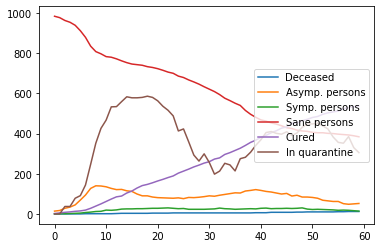

In [108]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

init_graph()

fig = plt.figure()
ax = fig.add_subplot()
xs = []
y_D = []
y_MS = []
y_MAS = []
y_S = []
y_G = []
y_Q = []

def update_viz():
    xs.append(len(xs))
    y_D.append(nbDead)          # number de deceased
    y_MS.append(nbS)            # number of symptomatic persons 
    y_MAS.append(nbAS)          # number of asymptomatic persons
    y_S.append(nbSane)          # number of sane persons
    y_G.append(nbCured)         # number of cured persons
    y_Q.append(nbQuarantine)    # number of people in quarantine
    
def draw_viz():
    ax.clear()
    def plot_with_label(ys, label):
        line, = ax.plot(xs, ys)
        line.set_label(label)
    plot_with_label(y_D, "Deceased")
    plot_with_label(y_MAS, "Asymp. persons")
    plot_with_label(y_MS, "Symp. persons")
    plot_with_label(y_S, "Sane persons")
    plot_with_label(y_G, "Cured")
    plot_with_label(y_Q, "In quarantine")

    ax.legend(loc='right')

nbSteps = 60
for _ in range(nbSteps):
    # update simulation
    step()
    # update matplotlib
    update_viz()
draw_viz()